In [3]:
import os
import cv2
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
image_dir_org = './test_data/test_images/'
image_dir_mask = './test_data/test_results/'
org_list = sorted(glob.glob(image_dir_org + os.sep + '*'))
mask_list = sorted(glob.glob(image_dir_mask + os.sep + '*'))

In [4]:
def bbox_by_black(img):
    
    block=2
    center_distance_ratio=1/4
    
    top=0
    bot=0
    left=0
    right=0

    for y in range(int(img[:,:,0].shape[0]/2+img[:,:,0].shape[0]*center_distance_ratio),img[:,:,0].shape[0]-1):
        if img[y,:,0].mean()<block:
            top=y
            break
    if top==0:
        top=img[:,:,0].shape[0]


    for y in range(int(img[:,:,0].shape[0]/2-img[:,:,0].shape[0]*center_distance_ratio),0,-1):
        if img[y,:,0].mean()<block:
            bot=y
            break


    for x in range(int(img[bot:top,:,0].shape[1]/2+img[bot:top,:,0].shape[1]*center_distance_ratio),img[bot:top,:,0].shape[1]-1):
        if img[bot:top,x,0].mean()<block:
            right=x
            break

    if right==0:
        right=img[bot:top,:,0].shape[1]


    for x in range(int(img[bot:top,:,0].shape[1]/2-img[bot:top,:,0].shape[1]*center_distance_ratio),0,-1):
        if img[bot:top,x,0].mean()<block:
            left=x
            break
    
    return left,right,bot,top

In [5]:
def preprocess(file_path, img_size=224):
    img_bgr = cv2.imread(file_path)
    thresh = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    x1, x2, y1, y2 = bbox_by_black(thresh)
    crop_img = img_bgr[y1:y2, x1:x2].astype('float32')
    img = tf.image.resize_with_pad(crop_img, img_size, img_size)
    return img

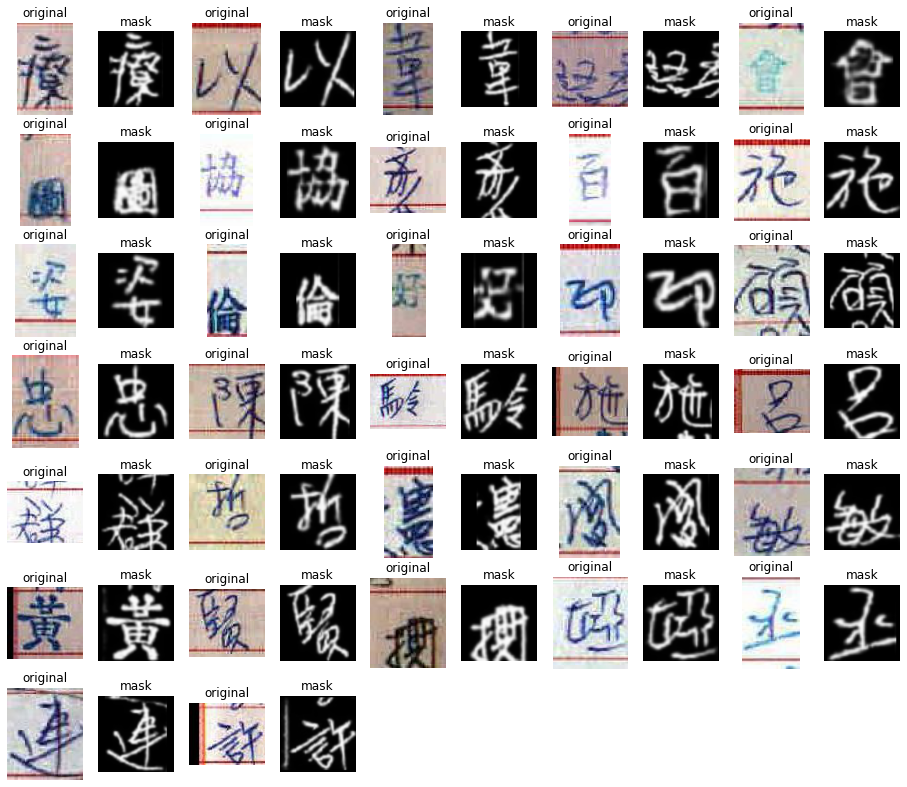

In [6]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

title = ['original','mask']
img_num= len(org_list)//10*3
plt.figure(figsize=(16,20*img_num/10))
cnt = 0
for org, mask in zip(org_list, mask_list):
    
    image_o = cv2.imread(org, cv2.IMREAD_UNCHANGED)[:,:,::-1]
    image_m = preprocess(mask)/255
    images = [image_o,image_m]

    
    for j in range(2):
        if j == 0:
            plt.subplot(img_num,10,cnt*2+j+1),plt.imshow(images[j]),plt.title(title[j])
            plt.axis('off')
        else:
            plt.subplot(img_num,10,cnt*2+j+1),plt.imshow(images[j], cmap='gray'),plt.title(title[j])
            plt.axis('off')
    plt.xticks([]),plt.yticks([])
    cnt+=1

plt.savefig("word.png")

In [ ]:
def get_word(arr, axis):
    a = np.sum(arr-255, axis=axis)
    b = (a > min(a))*1
    t = []
    sum = 0
    for i in range(len(b)-1):
        if b[i]!=b[i+1]:
            t.append(i)
        if b[i]==b[i+1] and i==len(b)-2:
            t.append(i+2)
    idx = np.argmax([t[i+1] - t[i] for i in range(len(t)-1)])
    if axis == 0:
        return arr[:, t[idx]:t[idx+1]]
    elif axis == 1:
        return arr[t[idx]:t[idx+1], :]

In [116]:
def get_bbox(img):
    img_y, img_x = (img > 20).nonzero()
    x1 = min(img_x)
    y1 = min(img_y)
    x2 = max(img_x)
    y2 = max(img_y)
    return x1, y1, x2, y2

(<matplotlib.axes._subplots.AxesSubplot at 0x7fda1ecbfb10>,
 <matplotlib.image.AxesImage at 0x7fda1ec2dd50>)

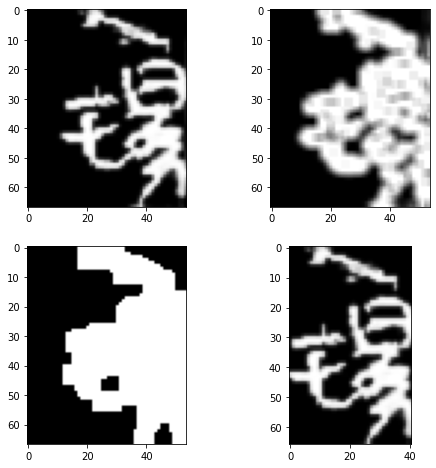

In [170]:
gray = cv2.imread(mask_list[1], 2)
gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)

# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

blurred = cv2.blur(gradient, (3, 3))
(_, thresh) = cv2.threshold(blurred, 90, 255, cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# perform a series of erosions and dilations
closed = cv2.erode(closed, None, iterations=3)
closed = cv2.dilate(closed, None, iterations=3)

(_, cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]

# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.int0(cv2.boxPoints(rect))

Xs = [i[0] for i in box]
Ys = [i[1] for i in box]
x1 = min(Xs)
x2 = max(Xs)
y1 = min(Ys)
y2 = max(Ys)
hight = y2 - y1
width = x2 - x1
cropImg = gray[y1:y1+hight, x1:x1+width]

# x1, y1, x2, y2 = get_bbox(img)
# img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.figure(figsize=(8, 8))
plt.subplot(2,2,1), plt.imshow(gray, cmap='gray')
plt.subplot(2,2,2), plt.imshow(blurred, cmap='gray')
plt.subplot(2,2,3), plt.imshow(closed, cmap='gray')
plt.subplot(2,2,4), plt.imshow(cropImg, cmap='gray')